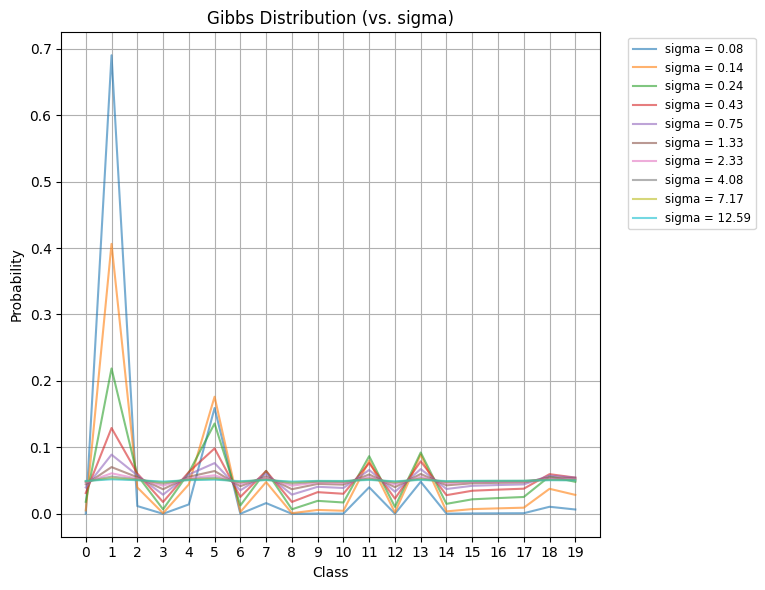

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def gibbs_prob_dist(energies, sigma):
    if sigma == 0:
        probs = np.zeros(len(energies))
        probs[np.argmin(energies)] = 1.0
        return probs
    unnormalized_probs = np.exp(-energies / sigma) 
    return unnormalized_probs / np.sum(unnormalized_probs)

k = 20
sigmas = np.logspace(-1.1, 1.1, 10)
energies = np.random.rand(k)

plt.figure(figsize=(8, 6))

for sigma in sigmas:
    probs = gibbs_prob_dist(energies, sigma)
    plt.plot(range(k), probs, label=f'sigma = {sigma:.2f}', alpha=0.6)

plt.xlabel('Class')
plt.ylabel('Probability')
plt.title(f'Gibbs Distribution (vs. sigma)')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize='small')
plt.xticks(np.arange(k))
plt.grid(True)

plt.tight_layout()
plt.show()

/tmp/ipykernel_956984/1476738577.py:7: RuntimeWarning: overflow encountered in exp
  numerator = np.sum(np.exp(scaling_factor * energies))
/tmp/ipykernel_956984/1476738577.py:8: RuntimeWarning: overflow encountered in scalar power
  denominator = np.sum(np.exp(energies))**scaling_factor
/tmp/ipykernel_956984/1476738577.py:9: RuntimeWarning: invalid value encountered in scalar divide
  return np.log(numerator / denominator)
/tmp/ipykernel_956984/1476738577.py:9: RuntimeWarning: divide by zero encountered in log
  return np.log(numerator / denominator)
/home/ubuntu/nethome-blazejb/minimol/.minimol_p3-12/lib/python3.12/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


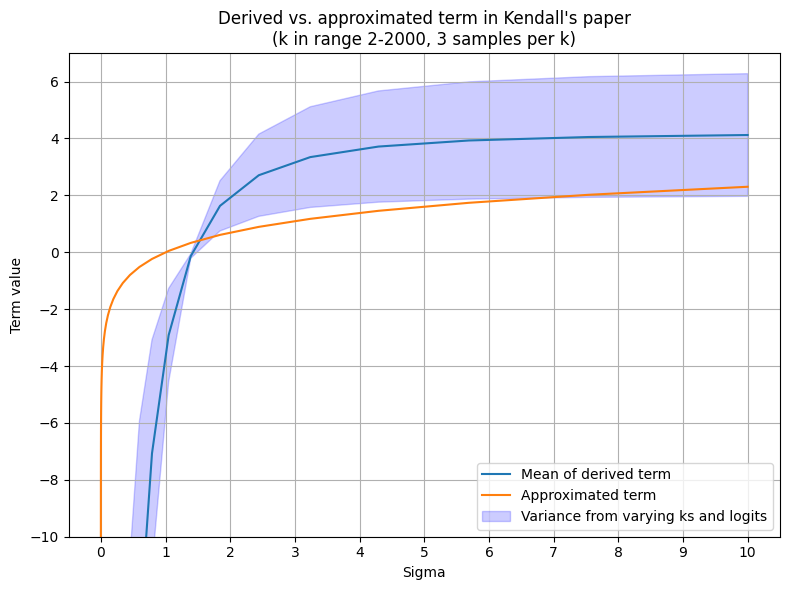

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random

def reg_term(energies, sigma):
    scaling_factor = 2 / sigma**2
    numerator = np.sum(np.exp(scaling_factor * energies))
    denominator = np.sum(np.exp(energies))**scaling_factor
    return np.log(numerator / denominator)

sigmas = np.logspace(-5, 1, 50)
ks = [2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000]
num_samples_per_k = 3
derived_curves = []

for k in ks:
    for _ in range(num_samples_per_k):
        logits = np.random.randn(k)
        derived_terms = [reg_term(logits, sigma) for sigma in sigmas]
        derived_curves.append(derived_terms)

derived_curves = np.array(derived_curves)

mean_derived = np.mean(derived_curves, axis=0)
var_derived = np.var(derived_curves, axis=0)

plt.figure(figsize=(8, 6))
plt.plot(sigmas, mean_derived, label='Mean of derived term')

approximated_terms = np.log(sigmas)
plt.plot(sigmas, approximated_terms, label='Approximated term')

plt.fill_between(sigmas, mean_derived - np.sqrt(var_derived), mean_derived + np.sqrt(var_derived), color='blue', alpha=0.2, label='Variance from varying ks and logits')

plt.ylim(-10, 7)
# plt.xscale('log')
plt.xlabel('Sigma')
plt.xticks(np.arange(max(sigmas) + 1))
plt.ylabel('Term value')
plt.title('Derived vs. approximated term in Kendall\'s paper\n(k in range 2-2000, 3 samples per k)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

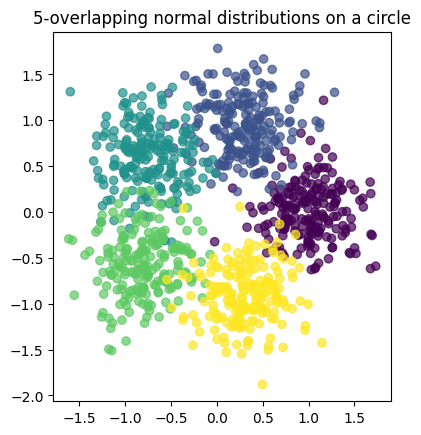

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def generate_gaussian_mixture_on_circle(n_classes=3, samples_per_class=100, radius=5.0, variance=1.0, random_state=None):
    X, y = [], []
    
    np.random.seed(random_state)
    angles = np.linspace(0, 2 * np.pi, n_classes, endpoint=False)
    
    for i, angle in enumerate(angles):
        mean = np.array([radius * np.cos(angle), radius * np.sin(angle)])
        covariance = np.eye(2) * variance
        samples = np.random.multivariate_normal(mean, covariance, samples_per_class)
        X.append(samples)
        y.append(np.full(samples_per_class, i))
    
    return np.vstack(X), np.hstack(y)

n_classes = 5
samples_per_class = 200
radius = 1.0
variance = 0.1

X, y = generate_gaussian_mixture_on_circle(
    radius=radius,
    random_state=42,
    variance=variance,
    n_classes=n_classes,
    samples_per_class=samples_per_class, 
) 

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(f"{n_classes}-overlapping normal distributions on a circle")
plt.show()